In [2]:
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#parametres initiaux du notebook du P 

nb_signals = 100
nb_dates_in_sample = 1300
nb_dates_out_sample = 260
nb_assets = 80

vol_assets = 0.2/16
correl_assets = 0.8

# vol_signals = 1.0
# correl_signals = 0.0

vol_signals = 0.2/16
correl_signals = 0.8

signal_to_noise = 0.001   # la relation entre rendements X et signaux Y n'est pas parfaitement proportionnelle à cause de ça ?

rank_betas = 5

Fonction qui renvoie un dataframe avec la moyenne des sharpes prédits out sample, la moyenne des sharpes optimaux théoriques, l'écart entre les 2 moyennes, et les valeurs des paramètres utilisés en input 
-> à voir si ça vaut le coup de ne pas mettre tous les paramètres dans le dataframe renvoyé par la fonction pour accélérer les calculs ? 

In [5]:
def prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas):
    
    liste_sharpes_predit = []
    liste_sharpes_optimaux_os=[]
    écart_sharpe_moyen=[]
    
    for i in range(nb_simus): 
        #partie generation des matrices de signaux et de rendements, d'entrainement et de test 
        cov_assets = vol_assets**2 * pd.DataFrame(correl_assets * np.ones((nb_assets,nb_assets)) + (1-correl_assets)*np.eye(nb_assets))
        cov_signals = vol_signals**2 * pd.DataFrame(correl_signals * np.ones((nb_signals,nb_signals)) + (1-correl_signals)*np.eye(nb_signals))

        betas = pd.DataFrame(np.random.randn(nb_signals,nb_assets)) 
        betas *= np.sqrt(signal_to_noise * np.trace(cov_assets) / np.trace(betas.T @ cov_signals @ betas))
        u,d,v = np.linalg.svd(betas)
        betas = pd.concat([pd.DataFrame(d[k] * np.outer(u[:,k],v[k,:]),index=betas.index,columns=betas.columns) for k in range(rank_betas)],keys=range(rank_betas)).groupby(level=1).sum()
        betas *= np.sqrt(signal_to_noise * np.trace(cov_assets) / np.trace(betas.T @ cov_signals @ betas))
    
        cov_noise = cov_assets - betas.T @ cov_signals @ betas
        d,P = np.linalg.eigh(cov_noise)
        cov_noise = pd.DataFrame(P @ np.diag(np.maximum(d,1e-10)) @ P.T)

        sqrt_cov_assets = np.linalg.cholesky(cov_assets)
        sqrt_cov_signals = np.linalg.cholesky(cov_signals)
        sqrt_cov_noise = np.linalg.cholesky(cov_noise)
    
        signals = pd.DataFrame(np.random.randn(nb_dates_in_sample,nb_signals) @ sqrt_cov_signals.T)
        noise = pd.DataFrame(np.random.randn(nb_dates_in_sample,nb_assets) @ sqrt_cov_noise.T)
        assets = signals @ betas+noise
    
        signals_os = pd.DataFrame(np.random.randn(nb_dates_out_sample,nb_signals) @ sqrt_cov_signals.T)
        noise_os = pd.DataFrame(np.random.randn(nb_dates_out_sample,nb_assets) @ sqrt_cov_noise.T)
        assets_os = signals_os @ betas+noise_os

    
    
        #partie entrainement et test du modele 
        modele.fit(signals,assets)
        prediction = modele.predict(signals_os) #ce truc est le vecteur des pondérations w=Y'f(Y)
        pnl_predit=(prediction * assets_os).sum(axis=1)   #Xw = le vecteur des pnls, on obtient pnl quand on somme les rendements quotidiens 
        liste_sharpes_predit.append(pnl_predit.mean()/pnl_predit.std()*16)
    
        #question : a quoi comparer pnl_predit et sharpe_predit? 
        #à pnl optimal out sample ou in sample ? ie avec Xtrain ou avec Xtest ?
        pnl_optimal_os = ((signals_os @ betas)*assets_os).sum(axis=1)
        liste_sharpes_optimaux_os.append(pnl_optimal_os.mean()/pnl_optimal_os.std()*16)
        
        écart_sharpe_moyen.append(pnl_optimal_os.mean()/pnl_optimal_os.std()*16 - pnl_predit.mean()/pnl_predit.std()*16)
       
    
    dic = {'nb_simus': nb_simus,
       'moyenne sharpes prédits': np.mean(liste_sharpes_predit),
       'moyenne sharpe optimaux': np.mean(liste_sharpes_optimaux_os),
       'écart moyen sharpe': np.mean(écart_sharpe_moyen),
       'nb_signals': nb_signals,
       'nb_dates_in_sample': nb_dates_in_sample,
       'nb_dates_out_sample': nb_dates_out_sample,
       'nb_assets': nb_assets,
       'vol_assets': vol_assets,
       'correl_assets': correl_assets,
       'vol_signals': vol_signals,
       'correl_signals': correl_signals,
       'signal_to_noise': signal_to_noise,
       'rank_betas': rank_betas}

    resultat = pd.DataFrame([dic])

    
    return resultat 

In [9]:
x=prediction_sharpe(modele=LinearRegression(fit_intercept=False), 
                    nb_simus=100,
                    nb_signals=100,
                    nb_dates_in_sample=1300,
                    nb_dates_out_sample=260,
                    nb_assets=80,
                    vol_assets=0.2/16,
                    correl_assets=0.8,
                    vol_signals=0.2/16,
                    correl_signals=0.8,
                    signal_to_noise=0.001,
                    rank_betas=5)

In [10]:
x

,nb_simus,moyenne sharpes prédits,moyenne sharpe optimaux,écart moyen sharpe,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas
0,100,0.243758,5.448453,5.204695,100,1300,260,80,0.0125,0.8,0.0125,0.8,0.001,5


remarque: le ridge ne fonctionne pas sur vs code (pb de compatibilité de python) il faut faire tourner sur ssp cloud pour obtenir des résultats...

In [11]:
def jolis_graphiques(modele, parametre_en_abscisse, min_abscisse, max_abscisse,pas, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas):

    
    abscisse = np.arange(min_abscisse,max_abscisse,pas) #abscisse
    sharpe_os = []
    sharpe_theo = []
    ecart_sharpe = []

    
    if parametre_en_abscisse == 'nombre_signaux' : 
        
        for i in abscisse : 

            sharpe_os.append(prediction_sharpe(modele, nb_simus, i,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,1])
            sharpe_theo.append(prediction_sharpe(modele, nb_simus,i,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,2])
            ecart_sharpe.append(prediction_sharpe(modele, nb_simus,i,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,3])


    elif parametre_en_abscisse == 'nombre_dates_in_sample' : 

        for i in abscisse:

            print(i)
            sharpe_os.append(prediction_sharpe(modele, nb_simus, nb_signals,i,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,1])
            sharpe_theo.append(prediction_sharpe(modele, nb_simus,nb_signals,i,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,2])
            ecart_sharpe.append(prediction_sharpe(modele, nb_simus,nb_signals,i,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,3])


    elif parametre_en_abscisse == 'nombre_dates_out_sample' : 

        for i in abscisse:

            sharpe_os.append(prediction_sharpe(modele, nb_simus, nb_signals,nb_dates_in_sample,i,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,1])
            sharpe_theo.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,i,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,2])
            ecart_sharpe.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,i,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,3])


    elif parametre_en_abscisse == 'nombre_actifs' : 

        for i in abscisse:

            sharpe_os.append(prediction_sharpe(modele, nb_simus, nb_signals,nb_dates_in_sample,nb_dates_out_sample,i,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,1])
            sharpe_theo.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,i,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,2])
            ecart_sharpe.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,i,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,3])


    elif parametre_en_abscisse == 'vol_actifs' : 

        for i in abscisse:

            sharpe_os.append(prediction_sharpe(modele, nb_simus, nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,i,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,1])
            sharpe_theo.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,i,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,2])
            ecart_sharpe.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,i,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,3])


    elif parametre_en_abscisse == 'correl_actifs' : 

        for i in abscisse:

            sharpe_os.append(prediction_sharpe(modele, nb_simus, nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      i,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,1])
            sharpe_theo.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      i,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,2])
            ecart_sharpe.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      i,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,3])



    elif parametre_en_abscisse == 'vol_signaux' : 

        for i in abscisse:

            sharpe_os.append(prediction_sharpe(modele, nb_simus, nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,i,correl_signals,signal_to_noise,rank_betas).iloc[0,1])
            sharpe_theo.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,i,correl_signals,signal_to_noise,rank_betas).iloc[0,2])
            ecart_sharpe.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,i,correl_signals,signal_to_noise,rank_betas).iloc[0,3])



    elif parametre_en_abscisse == 'correl_signaux' : 

        for i in abscisse:

            sharpe_os.append(prediction_sharpe(modele, nb_simus, nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,i,signal_to_noise,rank_betas).iloc[0,1])
            sharpe_theo.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,i,signal_to_noise,rank_betas).iloc[0,2])
            ecart_sharpe.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,i,signal_to_noise,rank_betas).iloc[0,3])



    elif parametre_en_abscisse == 'signal_sur_bruit' : 

        for i in abscisse:

            sharpe_os.append(prediction_sharpe(modele, nb_simus, nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,i,rank_betas).iloc[0,1])
            sharpe_theo.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,i,rank_betas).iloc[0,2])
            ecart_sharpe.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,i,rank_betas).iloc[0,3])



    else: 

        return ("pas un paramètre à faire varier fdp")


    plt.plot(abscisse, sharpe_os, label='sharpe out sample')
    plt.plot(abscisse, sharpe_theo, label='sharpe théorique optimal')
    plt.plot(abscisse, ecart_sharpe, label='écart entre sharpe OS et théorique')

    # Ajouter des labels et un titre
    plt.xlabel(parametre_en_abscisse)
    plt.ylabel('Valeurs des sharpes')
    plt.title(f'sharpe moyen pour {nb_simus} simulations avec le modèle {modele}')

    # Ajouter une légende
    plt.legend()

    # Afficher le tracé
    plt.show()
    

260
520
780
1040
1300
1560
1820
2080
2340
2600
2860
3120
3380
3640


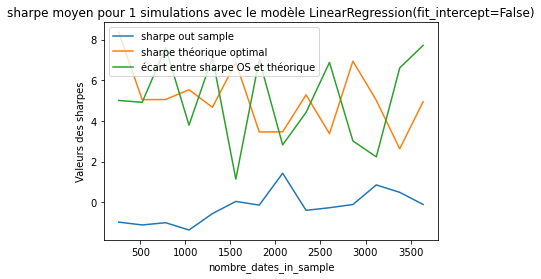

In [12]:
jolis_graphiques(modele=LinearRegression(fit_intercept=False), 
                 parametre_en_abscisse='nombre_dates_in_sample', 
                 min_abscisse=260, 
                 max_abscisse=260*15,
                 pas=260, 
                 nb_simus=1,
                 nb_signals=100,
                 nb_dates_in_sample=1300,
                 nb_dates_out_sample=260,
                 nb_assets=80,
                 vol_assets=0.2/16,
                 correl_assets=0.8,
                 vol_signals=0.2/16,
                 correl_signals=0.8,
                 signal_to_noise=0.001,
                 rank_betas=5)

idée: ce serait plus pertinent de produire un graphe qui renvoie le ratio sharpe_out_sample/(sharpe_theorique - sharpe_out_sample) associé à différentes méthodes, avec en abscisse le parametre qu'on fait varier.

Comme ça on capture à la fois la performance prédictive du modele au numérateur et l'overfitting au dénominateur et on peut comparer les différentes méthodes entre elles 